In [5]:
import numpy as np
import pandas as pd
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from scipy import stats
import joblib
import spacy
import gensim 

import pyLDAvis
import pyLDAvis.sklearn

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt

import sys  
sys.path.insert(0, '../src/')
from helper_functions import stringy_soup, lemmatize, sent_to_words, make_bigrams

In [54]:
plt.style.use('ggplot')

In [10]:
model = joblib.load('../results/lda_randomgrid_model.joblib')
word_vec = joblib.load('../results/word_matrix.joblib')
vectorizer = joblib.load('../results/vectorizer.joblib')

In [13]:
bill_text_df = pd.read_csv('../results/116bill_text.csv')

In [14]:
best_lda_model = model.best_estimator_
print(best_lda_model)
print(vectorizer)

LatentDirichletAllocation(doc_topic_prior=0.1, learning_decay=0.6,
                          learning_method='online', n_components=35, n_jobs=-1,
                          random_state=0, topic_word_prior=0.1)
CountVectorizer(max_df=0.9, max_features=6000, min_df=3)


In [15]:
ldavis = pyLDAvis.sklearn.prepare(best_lda_model, word_vec, vectorizer)

pyLDAvis.display(ldavis) 


In [16]:
pyLDAvis.save_html(ldavis, '../viz/lda_viz.html')

In [17]:
lda_output = best_lda_model.transform(word_vec)

In [28]:
topic_nums = [str(i) for i in range(best_lda_model.n_components)]
docnames = [bill_text_df['bill_num']]
doc_topic_df = pd.DataFrame(lda_output, columns=topic_nums, index=docnames)


In [29]:
topic_names = {0: 'Domestic Violence and Sex Crimes',
               1: 'Housing',
               2: 'Native American',
               3: 'Transportation',
               4: 'Drugs',
               5: 'Establishing/Regulating Agencies/Commissions/Councils',
               6: 'Military/National Security',
               7: 'Social Programs',
               8: 'Food Agriculture',
               9: 'Business/Finance',
               10: 'Financial Sector',
               11: 'Consumer Protection?',
               12: '??',
               13: 'Labor',
               14: 'Environment/Public Lands',
               15: 'Law Enforcement',
               16: 'Firearms',
               17: 'Naming Post Offices and other landmarks',
               18: 'Veterans',
               19: 'Appropriations',
               20: 'Foreign Affairs',
               21: 'Environmental Protection',
               22: 'Health Insurance',
               23: 'Immigration',
               24: 'Education',
               25: 'Homeland Security',
               26: 'China',
               27: 'Amendments',
               28: 'Science and Technology',
               29: 'Covid/Emergency',
               30: 'Voting',
               31: 'Tax',
               32: 'Family',
               33: 'Healthcare',
               34: 'Energy'}

In [30]:
doc_topic_df.columns = list(topic_names.values())

In [31]:
dominant_topic_1 = np.argsort(doc_topic_df.values, axis=1)[:,-1]
dominant_topic_2 = np.argsort(doc_topic_df.values, axis=1)[:,-2]

In [32]:
doc_topic_df['dom_topic1'] = dominant_topic_1
doc_topic_df['dom_topic2'] = dominant_topic_2

In [33]:
doc_topic_df['Tax'].nlargest(3)

bill_num
hr6554      0.956682
hr7346      0.926137
hr7324      0.923409
Name: Tax, dtype: float64

In [48]:
df_topic_distribution = doc_topic_df['dom_topic1'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic', 'Number of Documents']
df_topic_distribution.sort_values('Number of Documents', inplace=True)
df_topic_distribution.replace({'Topic': topic_names}, inplace=True)

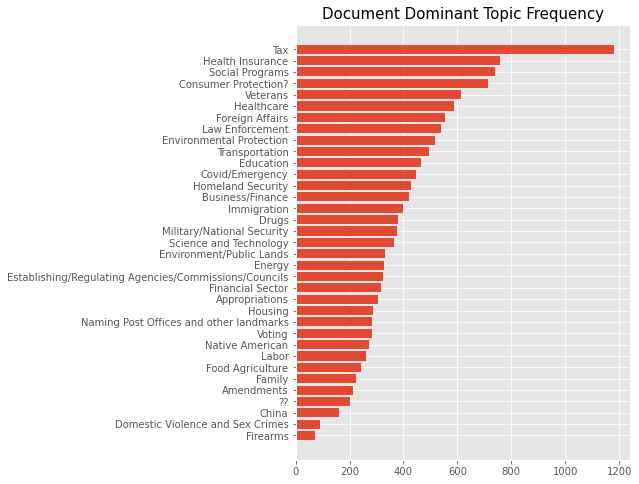

In [58]:
x = df_topic_distribution['Topic']
y = df_topic_distribution['Number of Documents']

fig, ax = plt.subplots(figsize=(6,8))
ax.barh(x, y)
ax.set_title('Document Dominant Topic Frequency', size=15)
fig.savefig('../viz/Dom_topic_freq.png', bbox_inches = "tight")

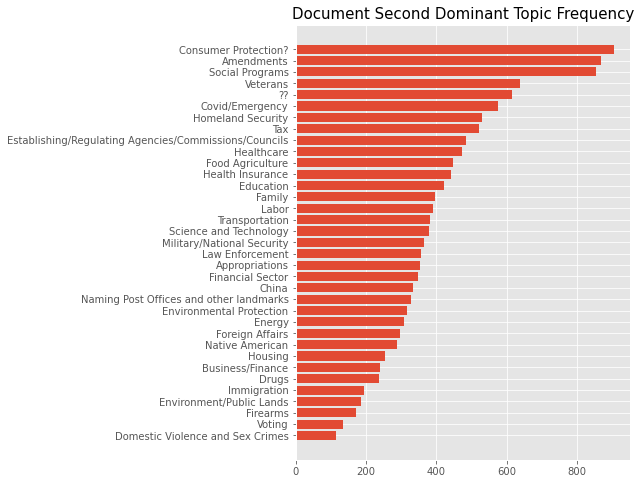

In [60]:
df_topic_distribution = doc_topic_df['dom_topic2'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic', 'Number of Documents']
df_topic_distribution.sort_values('Number of Documents', inplace=True)
df_topic_distribution.replace({'Topic': topic_names}, inplace=True)

x = df_topic_distribution['Topic']
y = df_topic_distribution['Number of Documents']

fig, ax = plt.subplots(figsize=(6,8))
ax.barh(x, y)
ax.set_title('Document Second Dominant Topic Frequency', size=15)
fig.savefig('../viz/Dom_topic2_freq.png', bbox_inches = "tight")

In [77]:
doc_topic_copy = doc_topic_df.copy()
doc_topic_copy.pop('dom_topic1')
doc_topic_copy.pop('dom_topic2')


In [80]:
doc_p50 = doc_topic_copy[doc_topic_copy>.5]
doc_p50.dropna(how='all', inplace=True)
doc_p50.dropna(how='all', axis=1, inplace=True)
doc_p50.fillna(0.0001, inplace=True)
dominant_topic = np.argmax(doc_p50.values, axis=1)
doc_p50['dominant_topic'] = dominant_topic

doc_p50_dist = doc_p50['dominant_topic'].value_counts().reset_index(name="Num Documents")
doc_p50_dist.columns = ['Topic', 'Number of Documents']

doc_p50_dist.replace({'Topic': topic_names}, inplace=True)
doc_p50_dist

,Topic,Number of Documents
0,Tax,656
1,Health Insurance,313
2,Consumer Protection?,217
3,Foreign Affairs,189
4,Business/Finance,171
5,Veterans,165
6,Law Enforcement,162
7,Social Programs,162
8,Environment/Public Lands,161
9,Immigration,159


<BarContainer object of 35 artists>

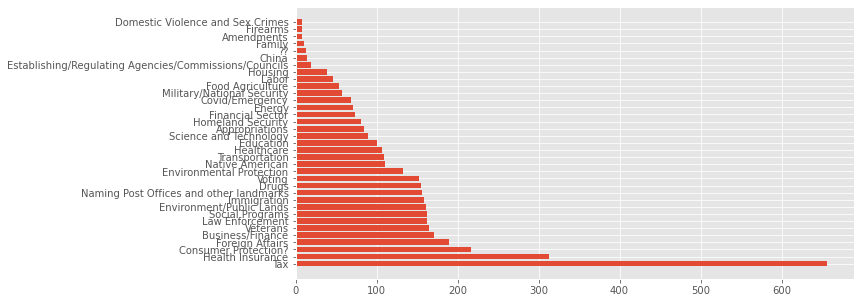

In [82]:
doc_p50_dist['Topic']= doc_p50_dist['Topic'].astype(str)

x = doc_p50_dist['Topic']
y = doc_p50_dist['Number of Documents']

fig, ax = plt.subplots(figsize=(10,5))
ax.barh(x, y)

In [92]:
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
# df_topic_keywords

In [93]:
lda_model = best_lda_model

In [94]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords


In [96]:

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=8)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = topic_names.values()
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7
Domestic Violence and Sex Crimes,violence,sexual,domestic,victim,assault,claim,include,abuse
Housing,housing,consumer,credit,assistance,financial,agency,unit,provide
Native American,indian,tribe,water,land,tribal,federal,state,agreement
Transportation,transportation,service,vehicle,code,federal,commission,safety,infrastructure
Drugs,drug,product,food,manufacturer,use,price,cosmetic,federal
Establishing/Regulating Agencies/Commissions/Councils,agency,director,office,federal,national,department,intelligence,government
Military/National Security,defense,force,military,department,armed,member,air,service
Social Programs,grant,program,state,eligible,entity,fund,local,provide
Food Agriculture,food,agriculture,agricultural,purpose,abortion,nutrition,twice,animal
Business/Finance,loan,business,small,borrower,make,payment,amount,federal


In [100]:
bill_info_df = pd.read_csv('../116bill_info.csv')

In [101]:
bills_df = bill_text_df.merge(bill_info_df, how='left', on='bill_num')

In [102]:
large_df = doc_topic_df.merge(bills_df, how='inner',on='bill_num')

In [113]:
doc_topic_df['Covid/Emergency'].nlargest(3)

bill_num
hr6206      0.904718
hr6288      0.777391
hr7018      0.756333
Name: Covid/Emergency, dtype: float64

In [120]:
for i in bill_info_df['official_title'][bill_info_df['bill_num']=='hr21']:
    print(i)

Making appropriations for the fiscal year ending September 30, 2019, and for other purposes.


Predict New Text

In [122]:
nlp = spacy.load('en_core_web_md')
nlp.max_length = 20000000

def preprocess(new_text, nlp=nlp):
    lemmatized_text = stringy_soup(lemmatize(new_text))
    data_words = list(sent_to_words(lemmatized_text))
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=400)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    data_words_bigrams = [bigram_mod[doc] for doc in data_words]
    processed_text = [' '.join(w) for w in data_words_bigrams]
    return processed_text

In [124]:
bill_text_115_df = pd.read_csv('../results/115bill_text.csv')

In [126]:
new_text = bill_text_115_df.iloc[325]['text']

In [127]:
def preprocess(new_text, nlp=nlp):
    lemmatized_text = stringy_soup(lemmatize(new_text))
    return pd.Series(lemmatized_text)

def vectorize_and_predict(new_text, vectorizer=vectorizer):
    new_text_word_vec = vectorizer.transform(preprocess(new_text))

    topic_probability_scores = best_lda_model.transform(new_text_word_vec)
    topic_keywords = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    topic = np.argmax(topic_probability_scores)
    return topic_probability_scores, topic_keywords, topic

In [128]:

topic_prob, kw, topic = vectorize_and_predict(new_text)

In [130]:
for i in topic_prob:
    probs = i

In [132]:
new_text_prob_topics = pd.DataFrame({'Topic': topic_names.values(), 'Probability':probs})

In [134]:
new_text_prob_topics.sort_values(by='Probability', inplace=True, ascending=False)

In [143]:
new_text_prob_topics.head(3)

,Topic,Probability
31,Tax,0.312791
8,Food Agriculture,0.192729
7,Social Programs,0.162624


In [137]:
bill_info_115_df = joblib.load('../115bill_info.joblib')


In [138]:
bills115_df = bill_text_115_df.merge(bill_info_115_df, how='left', on='bill_num')

In [139]:
bills115_df.iloc[325]['official_title']

'A bill to amend the Internal Revenue Code of 1986 to establish a new tax credit and grant program to stimulate investment and healthy nutrition options in food deserts, and for other purposes.'

In [146]:
bills115_df.iloc[325]['text']

'amend internal revenue code establish new tax credit grant program stimulate investment healthy nutrition option food desert purpose senate august warner moran capito casey follow read twice refer committee finance amend internal revenue code establish new tax credit grant program stimulate investment healthy nutrition option food desert purpose enact senate representatives america assemble short may cite healthy food access americans tax credit grant program special access food provider general allowance credit subpart part subchapter chapter internal revenue code amend add end follow new special access food provider credit grant program establishment credit grocery store general purpose special access food provider credit determine taxable year amount equal less amount allocation receive taxpayer amount equal case qualified grocery store place service taxable year taxpayer certify special access food provider percent basis grocery store include property use operation grocery store a